In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import keras
from keras import layers

import tensorflow as tf

2024-01-09 22:31:36.995130: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 22:31:37.015839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 22:31:37.015855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 22:31:37.016449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-09 22:31:37.020090: I tensorflow/core/platform/cpu_feature_guar

In [3]:
random.seed(10)

IMAGE_SIZE = 128
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    # in order to avoid `NONE` during shape inference
    low_image_cropped.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    enhanced_image_cropped.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("./lol_dataset/our485/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("./lol_dataset/our485/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))
test_enhanced_images = sorted(glob("./lol_dataset/eval15/high/*"))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


print("Train Dataset:", train_dataset.element_spec)
print("Val Dataset:", val_dataset.element_spec)

2024-01-09 22:31:38.198371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 22:31:38.231800: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 22:31:38.231888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Train Dataset: (TensorSpec(shape=(4, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 128, 128, 3), dtype=tf.float32, name=None))
Val Dataset: (TensorSpec(shape=(4, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 128, 128, 3), dtype=tf.float32, name=None))


In [4]:
def selective_kernel_feature_fusion(
    multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3
):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = layers.Add()(
        [multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3]
    )
    gap = layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = layers.Reshape((1, 1, channels))(gap)
    compact_feature_representation = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(channel_wise_statistics)
    feature_descriptor_1 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_2 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_3 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature

In [5]:
class ChannelPooling(layers.Layer):
    def __init__(self, axis=-1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.axis = axis
        self.concat = layers.Concatenate(axis=self.axis)

    def call(self, inputs):
        average_pooling = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        max_pooling = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        return self.concat([average_pooling, max_pooling])

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})


def spatial_attention_block(input_tensor):
    compressed_feature_map = ChannelPooling(axis=-1)(input_tensor)
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(compressed_feature_map)
    feature_map = keras.activations.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = layers.Reshape((1, 1, channels))(average_pooling)
    feature_activations = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(feature_descriptor)
    feature_activations = layers.Conv2D(
        filters=channels, kernel_size=(1, 1), activation="sigmoid"
    )(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(
        feature_map
    )
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])

In [6]:
# Recursive Residual Modules


def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.MaxPooling2D()(main_branch)
    main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.MaxPooling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.UpSampling2D()(main_branch)
    main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.UpSampling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


# MRB Block
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau),
        level2_dau,
        up_sampling_module(level3_dau),
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(
        up_sampling_module(dual_attention_unit_block(level3_skff))
    )
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level2_dau_2, level3_dau_2)
    conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return layers.Add()([input_tensor, conv])

In [7]:
def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return layers.Add()([conv2, input_tensor])


def mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)


model = mirnet_model(num_rrg=3, num_mrb=2, channels=64)

Epoch 1/50


2024-01-09 22:32:32.731729: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-09 22:32:32.786981: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 22:32:33.021228: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 22:32:34.082183: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5c79c6d490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-09 22:32:34.082200: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-09 22:32:34.084834: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704814354.124527 2277378 device_compiler.

75/75 [==============================] - 118s 377ms/step - loss: 0.2003 - val_loss: 0.1320 - lr: 1.0000e-04
Epoch 2/50
75/75 [==============================] - 25s 338ms/step - loss: 0.1795 - val_loss: 0.1284 - lr: 1.0000e-04
Epoch 3/50
75/75 [==============================] - 25s 338ms/step - loss: 0.1680 - val_loss: 0.1214 - lr: 1.0000e-04
Epoch 4/50
75/75 [==============================] - 25s 338ms/step - loss: 0.1666 - val_loss: 0.1206 - lr: 1.0000e-04
Epoch 5/50
75/75 [==============================] - 25s 338ms/step - loss: 0.1669 - val_loss: 0.1290 - lr: 1.0000e-04
Epoch 6/50
75/75 [==============================] - ETA: 0s - loss: 0.1570
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
75/75 [==============================] - 25s 338ms/step - loss: 0.1570 - val_loss: 0.1148 - lr: 1.0000e-04
Epoch 7/50
75/75 [==============================] - 25s 338ms/step - loss: 0.1476 - val_loss: 0.1133 - lr: 5.0000e-05
Epoch 8/50
75/75 [==========================

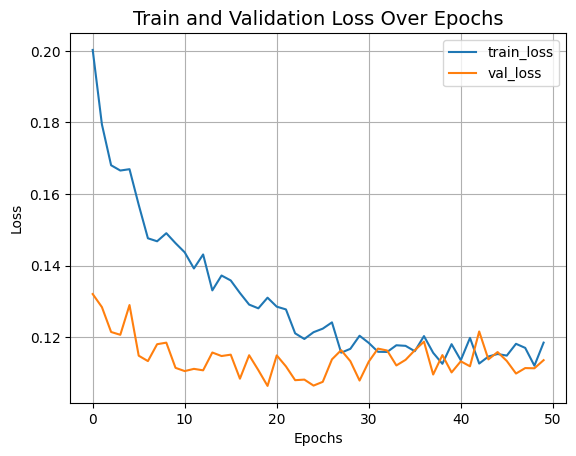

In [8]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss=charbonnier_loss,
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)


def plot_history(value, name):
    plt.plot(history.history[value], label=f"train_{name.lower()}")
    plt.plot(history.history[f"val_{value}"], label=f"val_{name.lower()}")
    plt.xlabel("Epochs")
    plt.ylabel(name)
    plt.title(f"Train and Validation {name} Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss", "Loss")

In [10]:
import os

import keras
import numpy as np
from model import mirnet_model
from PIL import Image
import time
def infer(original_image):
    start = time.time()
    image = keras.utils.img_to_array(original_image)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    output = model.predict(image, verbose=0)
    output_image = output[0] * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.reshape((np.shape(output_image)[0], np.shape(output_image)[1], 3))
    output_image = Image.fromarray(np.uint8(output_image))
    original_image = Image.fromarray(np.uint8(original_image))
    end = time.time()
    infer_time = end - start
    print(f'infer_time: {infer_time}')
    return output_image


test_low_light_images = os.listdir('/home/hiepdvh/MIRNET/lol_dataset/eval15/low')

for low_light_image in test_low_light_images:
    low_light_image_path = os.path.join(
        '/home/hiepdvh/MIRNET/lol_dataset/eval15/low', low_light_image
    )
    original_image = Image.open(low_light_image_path)
    enhanced_image = infer(original_image)
    enhanced_image.save(
        os.path.join(
            '/home/hiepdvh/MIRNET/lol_dataset/eval15/high',
            low_light_image,
        )
    )

infer_time: 0.3452162742614746
infer_time: 0.31330323219299316
infer_time: 0.31203341484069824
infer_time: 0.31081247329711914
infer_time: 0.31104278564453125
infer_time: 0.31111574172973633
infer_time: 0.31380152702331543
infer_time: 0.3121678829193115
infer_time: 0.311082124710083
infer_time: 0.31119465827941895
infer_time: 0.31230926513671875
infer_time: 0.3173248767852783
infer_time: 0.312896728515625
infer_time: 0.31279897689819336
infer_time: 0.31384968757629395


In [11]:
import os

import cv2
import numpy as np
import torch
from lpips import LPIPS
from scipy.stats import entropy
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


def calculate_metrics(original_img, enhanced_img):
    # Chuyển đổi ảnh từ [0, 255] sang [0, 1]
    original_img = original_img.astype(np.float32) / 255.0
    enhanced_img = enhanced_img.astype(np.float32) / 255.0
    original_img.resize(enhanced_img.shape)
    # PSNR
    psnr_value = psnr(original_img, enhanced_img, data_range=1.0)

    # SSIM
    ssim_value, _ = ssim(original_img, enhanced_img, full=True, data_range=1.0)

    # Entropy
    entropy_original = entropy(original_img.flatten())
    entropy_enhanced = entropy(enhanced_img.flatten())

    # Standard Deviation
    std_dev_original = np.std(original_img)
    std_dev_enhanced = np.std(enhanced_img)
    original_tensor = torch.from_numpy(original_img)
    enhanced_tensor = torch.from_numpy(enhanced_img)
    lpips_value = lpips_model(original_tensor, enhanced_tensor).item()
    return (
        psnr_value,
        ssim_value,
        entropy_original,
        entropy_enhanced,
        std_dev_original,
        std_dev_enhanced,
        lpips_value,
    )

In [12]:
lpips_model = LPIPS(net='vgg')
original_image_folder = (
    '/home/hiepdvh/MIRNET/lol_dataset/eval15/high'
)
enhanced_image_folder = (
    '/home/hiepdvh/MIRNET/lol_dataset/eval15/low'
)

images = os.listdir(original_image_folder)
results = ''
average_psnr = 0
average_ssim = 0
average_entropy = 0
average_std = 0
average_lpips = 0
for i, image in enumerate(images):
    original_image_path = os.path.join(original_image_folder, image)
    enhanced_image_path = os.path.join(enhanced_image_folder, image)
    original_img = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    enhanced_img = cv2.imread(enhanced_image_path, cv2.IMREAD_GRAYSCALE)

    (
        psnr_value,
        ssim_value,
        entropy_original,
        entropy_enhanced,
        std_dev_original,
        std_dev_enhanced,
        lpips_value,
    ) = calculate_metrics(original_img, enhanced_img)
    result = f'{image}\npsnr: {psnr_value}, ssim: {ssim_value}, entropy: {entropy_enhanced}, std: {std_dev_enhanced}, lpips: {lpips_value}'
    results = results + result + '\n'
    average_psnr = (average_psnr*i + psnr_value)/(i+1)
    average_ssim = (average_ssim*i + ssim_value)/(i+1)
    average_entropy = (average_entropy*i + entropy_enhanced)/(i+1)
    average_std= (average_std*i + std_dev_enhanced)/(i+1)
    average_lpips = (average_lpips*i + lpips_value)/(i+1)

print(results)
print(f' average_psnr: {average_psnr} \n average_ssim: {average_ssim} \n average_entropy: {average_entropy} \n average_std: {average_std} \n average_lpips: {average_lpips}')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/hiepdvh/miniconda3/envs/MIRNET/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hiepdvh/miniconda3/envs/MIRNET/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/hiepdvh/miniconda3/envs/MIRNET/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth
665.png
psnr: 6.477215137862161, ssim: 0.09810390735282001, entropy: 12.1690034866333, std: 0.019163131713867188, lpips: 0.39847099781036377
22.png
psnr: 6.982565430338394, ssim: 0.2173781299031865, entropy: 12.101876258850098, std: 0.0507991686463356, lpips: 0.3305858373641968
778.png
psnr: 7.665383331158656, ssim: 0.07796853593015238, entropy: 11.859112739562988, std: 0.02995860017836094, lpips: 0.3813781142234802
780.png
psnr: 8.003217594792272, ssim: 0.12080670215625897, entropy: 11.887100219726562, std: 0.05470995232462883, lpips: 0.36735618114471436
111.png
psnr: 7.009518318936157, ssim: 0.21244629576627033, entropy: 12.224459648132324, std: 0.042161352932453156, lpips: 0.31651604175567627
146.png
psnr: 6.456054803695109, ssim: 0.26110652533420425, entropy: 12.196784973144531, std: 0.04989078640937805, lpips: 0.3307109773159027
493.png
psnr: 7.625403108589909, ssim: 0.